In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
import cv2
from PIL import Image

## Load data

In [12]:
network_dim = int(256/2)  # ensure that this is always greater than max node number that occurs in your data
                      # in addition it needs to fit to the unet layer for concatenation

In [3]:
#graphs
# #masks = glob.glob("../input/graph_images/train/label/*.png")
# masks = np.load('../input/graph_images/train/label/adjcouput_matrix.npy',allow_pickle='TRUE').item()
# orgs = glob.glob("../input/graph_images/train/image/*.png")
#training images
#masks = np.load('S:/06_Studienarbeit/03_CNN/generate_data/data/train/label/adjcouput_matrix.npy',allow_pickle='TRUE').item()
masks = glob.glob('S:/studenten/Rausch/06_Studienarbeit/03_CNN/generate_data/data/train_less128_2000imgs/label/*')
masks = masks[0:803]
orgs = glob.glob("S:/studenten/Rausch/06_Studienarbeit/03_CNN/generate_data/data/train_less128_2000imgs/image/*.png")
orgs = orgs[0:803]
#every training image has less than 128 nodes

In [4]:
#training images
imgs_list = []
masks_list = []
for image, mask in zip(orgs, masks):
    I = cv2.imread(image)
    key = image
    graph_label = np.load(masks[int(key[-14:-9])], allow_pickle=True)
    graph_label_norm = graph_label.copy()
    positions = graph_label[:, :2, 0]
    #normalize positions
    pos_norm = np.zeros(positions.shape)
    for i in range(len(positions)):
        pos_norm[i][0] = np.round((positions[i][0]/I.shape[1])*512, 0)
        pos_norm[i][1] = np.round((positions[i][1] /I.shape[0])*512, 0)
    graph_label_norm[:, :2, 0] = pos_norm
    #pad the label to obtain uniform array sizes
    #graph_label_padded = np.pad(graph_label_norm, ((0, network_dim-graph_label.shape[0]), (0, network_dim-graph_label.shape[1]), (-9.9, -9.9)))
    #graph_label_padded = np.pad(graph_label_norm, ((0, 0), (0, 0), (0, 0)))
    #graph_label_padded = graph_label_norm
    imgs_list.append(np.array(Image.open(image).convert('L').resize((512,512))))
    #print(graph_label_padded)
    #masks_list_position.append(np.array(graph_label_norm[:, 0:2, 0]))
    #masks_list_adjacency.append(np.array(graph_label_norm[:, 2:, 0]))
    masks_list.append(graph_label_norm)
imgs_np = np.asarray(imgs_list)

## Plot images + masks + overlay (mask over original)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


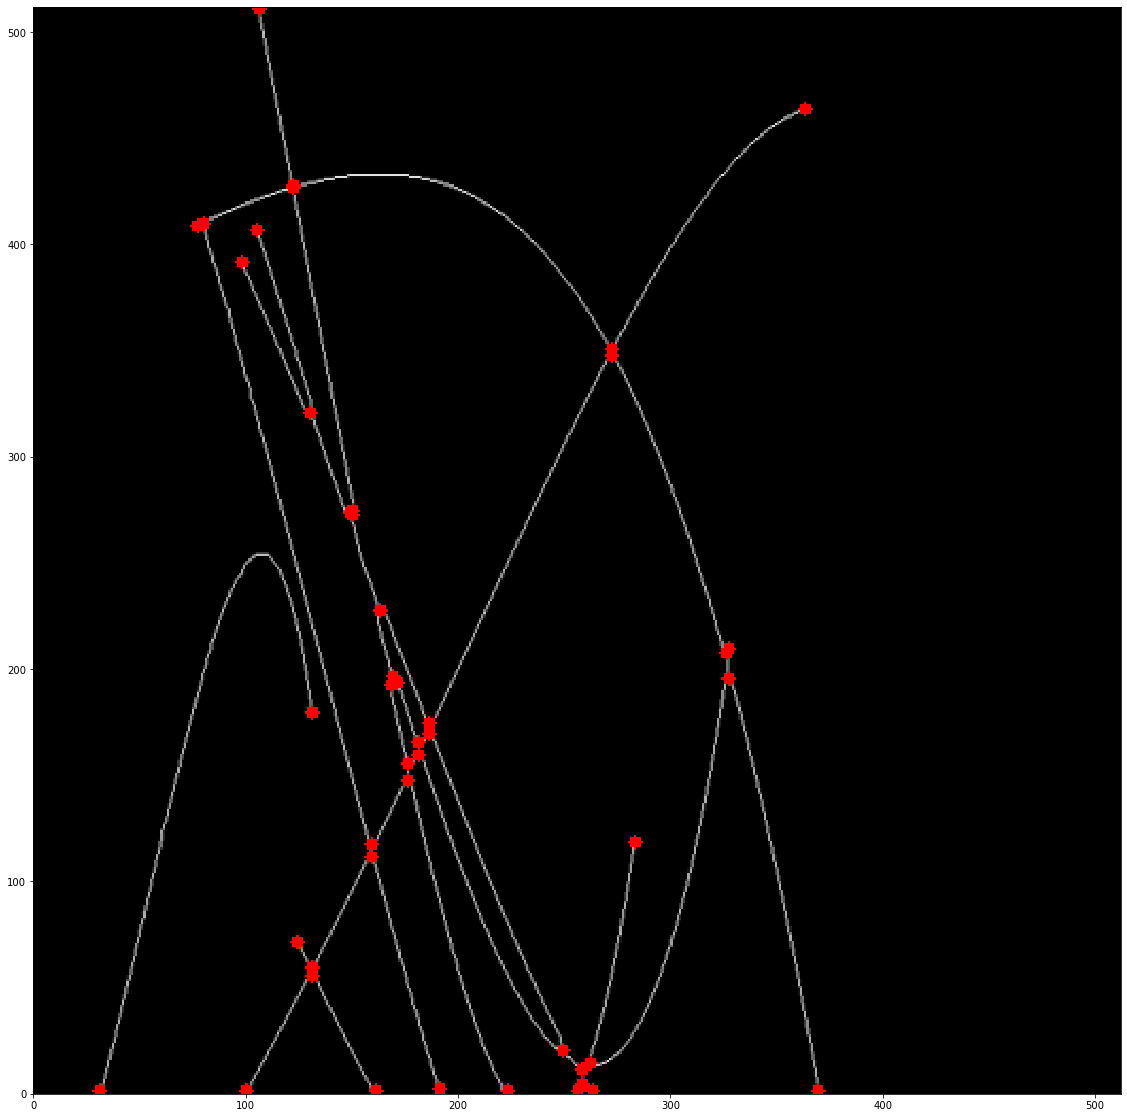

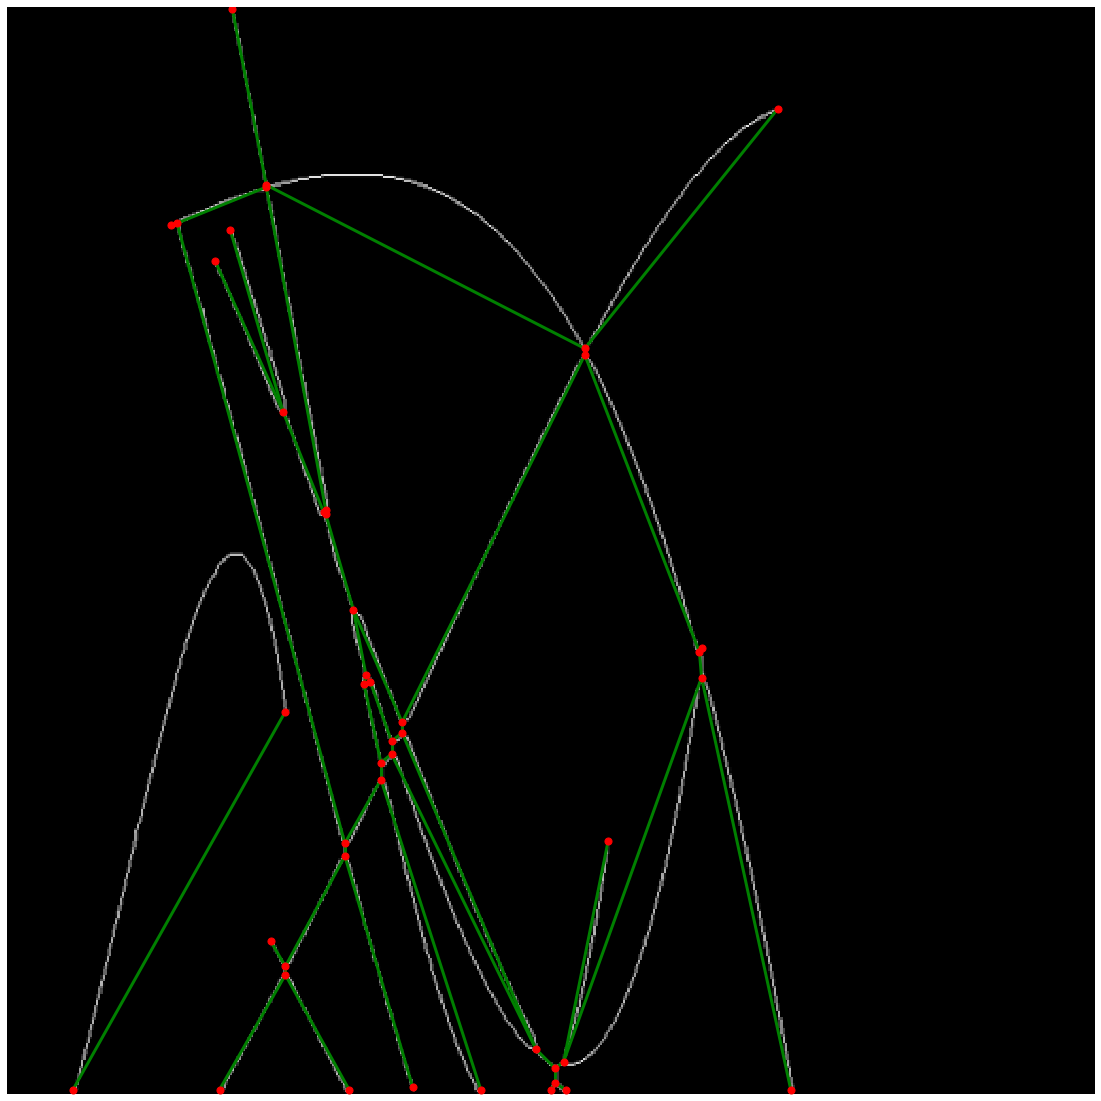

In [5]:
from keras_unet.utils_regine import plot_graph_on_img, plot_nodes_on_img
node_thick = 6
index = 3
save = True

masks_np = np.asarray(masks_list[index])
#uniform array sizes are necessary
y_positions_label = masks_np[:,0:2, 0]
y_adjacency_label = masks_np[:,2:, 0]
node_img = plot_nodes_on_img(imgs_np[index,:,:], y_positions_label, node_thick)
fig = plot_graph_on_img(imgs_np[index,:,:], y_positions_label, y_adjacency_label)

In [13]:
#network_dim = 15
   # tailor the data to the specific pre defined network dimension
pos_vec = np.full((len(masks_list),network_dim *2), -9.9)
adj_flatten_dim = int((network_dim*network_dim-network_dim)/2)

adj_vec = np.zeros((len(masks_list),adj_flatten_dim))
#for index in range(len(masks_list)):
for index in range(1):
    adj_mat = np.zeros((network_dim,network_dim))
    pos_mat = np.full((network_dim,2), -9.9)
    masks_np = np.asarray(masks_list[index])
    y_label_positions = masks_np[:,0:2, 0] # last zero --> without attributes
    y_label_adjacency = masks_np[:,2:, 0]  # last zero --> without attributes

    if y_label_positions.shape[0] >= network_dim *2:
        print('the number of labeld nodes/frame is too high for network dimension - decrease nodes in training data or consider to adapt the network size')
        pos_mat[0:network_dim,:] = y_label_positions[0:network_dim,:]
        adj_mat[0:network_dim,0:network_dim]= y_label_adjacency[0:network_dim,0:network_dim]
    else:
        #print('y_label_adjacency.shape',y_label_adjacency.shape[0])
        pos_mat[0:np.shape(y_label_positions)[0],:] = y_label_positions
        adj_mat[0:np.shape(y_label_adjacency)[0],0:np.shape(y_label_adjacency)[1]]= y_label_adjacency
  # form position matrix and adjacency in a one dimensional vector information
    pos_mat = pos_mat.reshape((network_dim*2))
    pos_vec[index,0:network_dim*2] = pos_mat

    adjacency_label_indices = np.triu_indices(network_dim, k = 1)
    adj_vec[index,0:adj_flatten_dim] = adj_mat[adjacency_label_indices]




y_label = [pos_vec, adj_vec]
print('total number of positions: ', y_label[0].shape)
print('total number of relevant adjacency entries: ', y_label[1].shape)

total number of positions:  (803, 256)
total number of relevant adjacency entries:  (803, 8128)


## Get data into correct shape, dtype and range (0.0-1.0)

In [7]:
print(imgs_np.max(), masks_np.max())
x = np.asarray(imgs_np, dtype=np.float32)/255
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)

255 510.0


In [14]:
#reshape
from keras_unet.utils_regine import plot_graph_on_img, plot_nodes_on_img
from models_graph.prepare_functions import create_adj_matrix, create_position_matrix
cut_off = network_dim
idx_init = 0
split_initial_img = x[idx_init,:,:,0]
split_initial_pos = y_label[0][idx_init,:]
split_initial_adj = y_label[1][idx_init,:]

split_initial_img_mat = split_initial_img
split_initial_pos_mat= create_position_matrix(split_initial_pos,cut_off)
split_initial_adj_mat = create_adj_matrix(split_initial_adj,networksize=network_dim,cut_off_size = cut_off)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


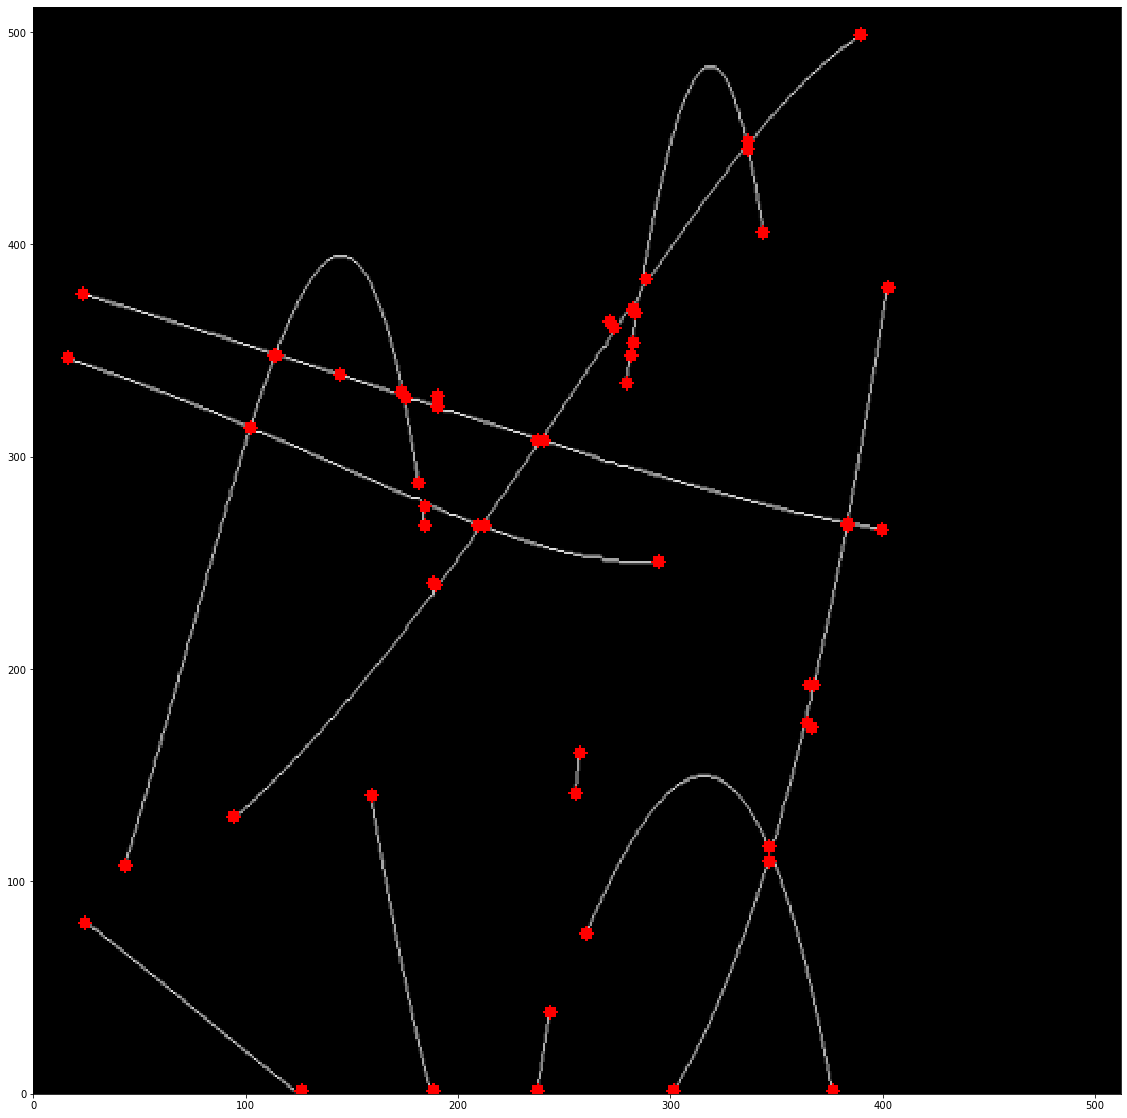

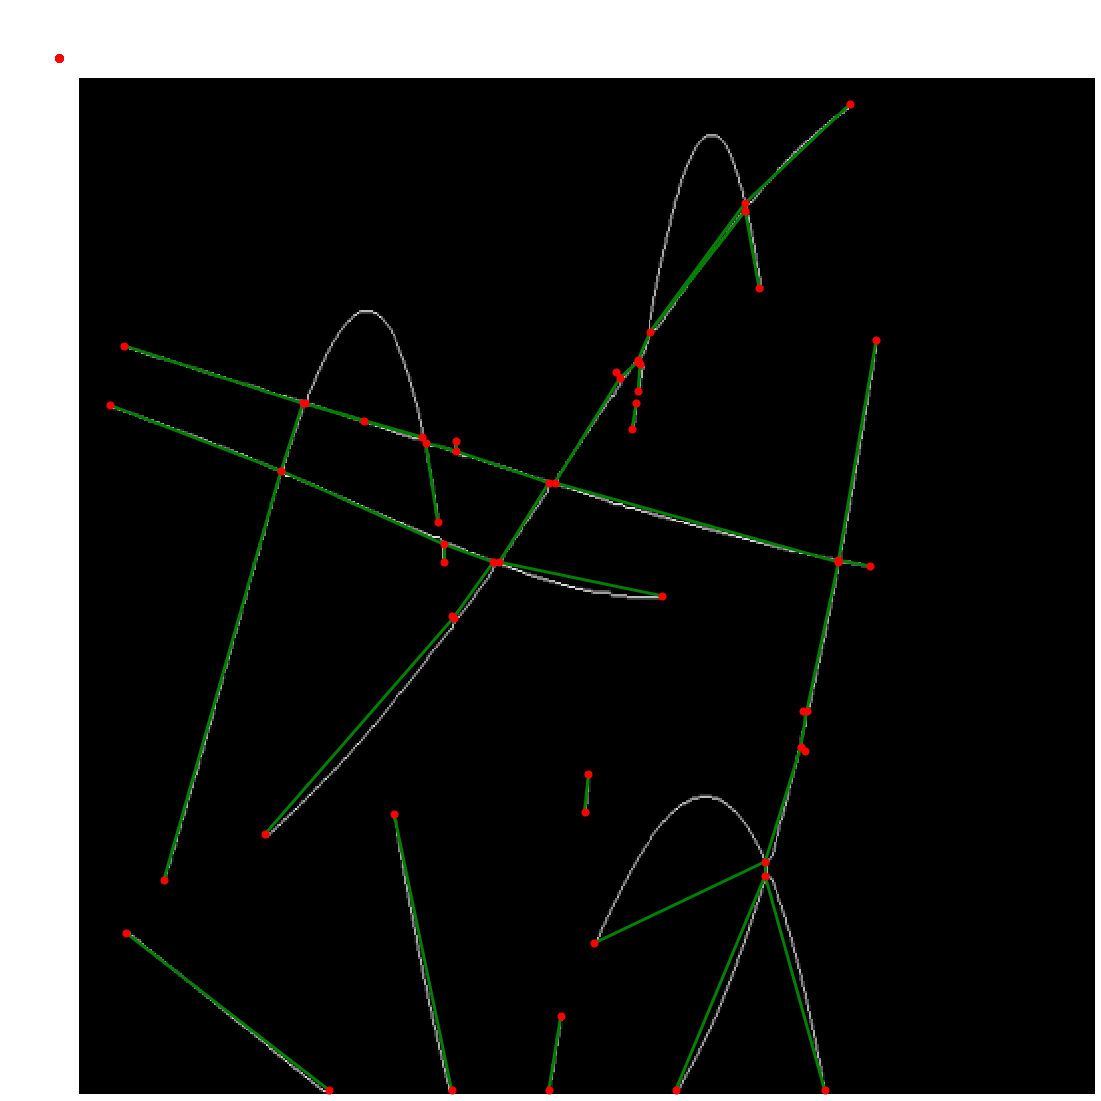

In [15]:


node_img = plot_nodes_on_img(split_initial_img_mat ,split_initial_pos_mat,node_thick)
fig = plot_graph_on_img(split_initial_img_mat,split_initial_pos_mat, split_initial_adj_mat)


In [ ]:
print(y_label_adjacency_matrix_original)
print(split_initial_adj_mat)

y_label_positions = masks_np[:,0:2, 0]
#print(y_label_positions)
#print(split_initial_pos_mat)
#print(split_initial_pos)
print(y_label_adjacency_list[0:30])
y_label_adjacency_list_mat = create_adj_matrix(y_label_adjacency_list,cut_off)
print(y_label_adjacency_list_mat)

In [ ]:
print(imgs_np.max(), masks_np.max())
x = np.asarray(imgs_np, dtype=np.float32)/255
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)

##  Train/val split

In [ ]:
from sklearn.model_selection import train_test_split
# split data
x_train, x_val, y_train_positions,y_val_positions, y_train_adjacency, y_val_adjacency = train_test_split(x, y_label[0], y_label[1],shuffle=False, test_size=0.1, random_state=0)
from models_graph.prepare_functions import convert_to_tensor
# convert from numpy to tensorflow object
x_train = convert_to_tensor(x_train)
x_val = convert_to_tensor(x_val)
y_train_positions = convert_to_tensor(y_train_positions)
y_train_adjacency = convert_to_tensor(y_train_adjacency)
y_val_positions = convert_to_tensor(y_val_positions)
y_val_adjacency = convert_to_tensor(y_val_adjacency)

In [ ]:
print("x_train: ", x_train.shape)
print("y_train_positions: ", y_train_positions.shape)
print(" y_train_adjacency: ", y_train_adjacency.shape)
print("x_val: ", x_val.shape)
print("y_val_positions: ", y_val_positions.shape)
print("y_val_adjacency: ", y_val_adjacency.shape)


In [ ]:
#reshape
from keras_unet.utils_regine import plot_graph_on_img, plot_nodes_on_img
from models_graph.prepare_functions import create_adj_matrix, create_position_matrix
cut_off =30
idx_init = 3
split_initial_img = x[idx_init,:,:,0]
split_initial_pos = y_label[0][idx_init,:]
split_initial_adj = y_label[1][idx_init,:]

split_initial_img_mat = split_initial_img
split_initial_pos_mat= create_position_matrix(split_initial_pos,cut_off)
split_initial_adj_mat = create_adj_matrix(split_initial_adj,cut_off)

node_img = plot_nodes_on_img(split_initial_img_mat ,split_initial_pos_mat,node_thick)
fig = plot_graph_on_img(split_initial_img_mat,split_initial_pos_mat, split_initial_adj_mat)



In [ ]:
#reshape
from keras_unet.utils_regine import plot_graph_on_img, plot_nodes_on_img
from models_graph.prepare_functions import create_adj_matrix, create_position_matrix


idx_val = 3
idx_train = 3
idx_init = 3
split_val_img = x_val.numpy()[idx_val, :, :, 0]
split_val_pos = y_val_positions.numpy()[idx_val,:]
split_val_adj = y_val_adjacency.numpy()[idx_val,:]
split_train_img = x_train.numpy()[idx_train,:,:,0]
split_train_pos = y_train_positions.numpy()[idx_train,:]
split_train_adj = y_train_adjacency.numpy()[idx_train,:]
split_initial_img = x[idx_init,:,:,0]
split_initial_pos = y_label[0][idx_init,:]
split_initial_adj = y_label[1][idx_init,:]
cut_off =110

split_val_img_mat = split_val_img
split_val_pos_mat = create_position_matrix(split_val_pos,cut_off)
split_val_adj_mat = create_adj_matrix(split_val_adj,cut_off)
split_train_img_mat = split_train_img
split_train_pos_mat = create_position_matrix(split_train_pos,cut_off)
split_train_adj_mat = create_adj_matrix(split_train_adj,cut_off)
split_initial_img_mat = split_initial_img
split_initial_pos_mat= create_position_matrix(split_initial_pos,cut_off)
split_initial_adj_mat = create_adj_matrix(split_initial_adj,cut_off)




print('done')

In [ ]:
from keras_unet.utils_regine import plot_graph_on_img, plot_nodes_on_img
#plot nodes on img
node_thick = 6
index = 0

In [ ]:
node_img = plot_nodes_on_img(split_train_img_mat , split_train_pos_mat, node_thick)
fig = plot_graph_on_img(split_train_img_mat,split_train_pos_mat, split_train_adj_mat)

In [ ]:
node_img = plot_nodes_on_img(split_val_img_mat ,split_val_pos_mat, node_thick)
fig = plot_graph_on_img(split_val_img_mat,split_val_pos_mat, split_val_adj_mat)

In [ ]:
node_img = plot_nodes_on_img(split_initial_img_mat ,split_initial_pos_mat,node_thick)
fig = plot_graph_on_img(split_initial_img_mat,split_initial_pos_mat, split_initial_adj_mat)




#node_img = plot_nodes_on_img(x_train.numpy()[index, :, :, 0],predicted_positions0 , node_thick)
#fig = plot_graph_on_img(x_train.numpy()[index, :, :, 0], predicted_positions0 , predicted_adjacency0)

In [ ]:
print("x_train: ", x_train.shape)
print("y_train_positions: ", y_train_positions.shape)
print(" y_train_adjacency: ", y_train_adjacency.shape)
print("x_val: ", x_val.shape)
print("y_val_positions: ", y_val_positions.shape)
print("y_val_adjacency: ", y_val_adjacency.shape)

import numpy as np
index = 58


masks_np = np.asarray(masks_list[index])
#uniform array sizes are necessary
y_positions_label = masks_np[:,0:2, 0]
y_adjacency_label = masks_np[:,2:, 0]



position_label = y_train_positions.numpy()[index,:]
adjacency_label = y_train_adjacency.numpy()[index,:]

adjacency_label_matrix = create_adj_matrix(adjacency_label,60)
position_label_matrix = create_position_matrix(position_label,60)


node_thick = 6


node_img = plot_nodes_on_img(x_train.numpy()[index, :, :, 0], position_label_matrix, node_thick)
fig = plot_graph_on_img(x_train.numpy()[index, :, :, 0],position_label_matrix,adjacency_label_matrix )

node_img = plot_nodes_on_img(imgs_np[index,:,:], y_positions_label, node_thick)
fig = plot_graph_on_img(imgs_np[index,:,:], y_positions_label, y_adjacency_label)
#
print('orginal label: ',y_positions_label[1:5,:],'label reconstruct: ',position_label_matrix[1:5,:])
print('orginal label: ',y_adjacency_label[0:5,0:5],'label reconstruct: ',adjacency_label_matrix[0:5,0:5])

In [ ]:
def create_adj_matrix2(adj_vector, size = 35):
    adj_matrix = np.zeros((size, size))
    print('adj vecot',adj_vector)
    print(size)
    print('indices', np.triu_indices(size, k = 1))
    adj_matrix[np.triu_indices(size, k = 1)]  = adj_vector[0:np.shape(np.triu_indices(size, k = 1))[1]]
    print('adj vecot',adj_vector[0:np.shape(np.triu_indices(size, k = 1))[1]])
    print('adj matrix',adj_matrix )
    adj_matrix = adj_matrix+np.transpose(adj_matrix)
    print('adj matrix2',adj_matrix )
    return(adj_matrix)

adjacency_label_matrix2 = create_adj_matrix2(adjacency_label,5)
print('adj matrix 4: ',adjacency_label_matrix2)
print('label vector',adjacency_label)
#print('orginal label: ',y_positions_label[1:5,:],'label reconstruct: ',position_label_matrix[1:5,:])
print('orginal label: ',y_adjacency_label[1:5,1:5],'label reconstruct: ',adjacency_label_matrix2)

In [ ]:
adj_flatten_dim = int((network_dim*network_dim-network_dim)/2)
y_adjacency_label_org_test =y_adjacency_label
adjacency_label_indices = np.triu_indices(y_adjacency_label_org_test.shape[1], k = 1)
c = y_adjacency_label_org_test[adjacency_label_indices[0],adjacency_label_indices[1]]
y_adjacency_label_org_test = y_adjacency_label_org_test[adjacency_label_indices[0],adjacency_label_indices[1]]
print(c.shape)
print(adj_flatten_dim)
index=0
b = np.zeros((1,adj_flatten_dim))
if c.shape[0] >= adj_flatten_dim:
    print('the number of labeld nodes/frame is too high for network dimension - decrease nodes in training data or consider to adapt the network size')

    b[index,0:adj_flatten_dim] =c[0:adj_flatten_dim]
else:

    b[index,0:c.shape[0]] = c
y_label = [a, b]

print(b.shape)

adjacency_label_matrix3 = create_adj_matrix2(b[0,:],68)
print(np.shape(adjacency_label_matrix3))

if y_adjacency_label.all() == adjacency_label_matrix3.all():
    print(True)
else:
    print(None)

    print('orginal label: ',y_adjacency_label[1:8,1:8],'label reconstruct: ',adjacency_label_matrix3[1:8,1:8])


    # one d vecotr is unsorted somewhere, maybebe the split is the issue!!!!